In [99]:
from IPython.display import HTML

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

<h1><center>RATING THE CRITICS</center></h1>
<h2><center> An In-Depth Look at New York Times Film Critics and the Academy of Motion Picture Arts and Sciences Voting Membership</center></h2>
<br>
<center>University of Toronto - STA2453 - November 2018</center>
<center>David Veitch - 1004657917</center>








In this report I seek to answer three questions:

* **Are film critics from the New York Times (NYT) able to predict box office hits?**
* **What kind of storylines do NYT critics favour?**
* **What best picture nominees tend to win the Oscar?**

**Preliminaries**

* [Introduction](#introduction)

* [Data Collection](#datacollection)

**Analysis**

* [1. Are film critics from the NYT able to predict box office hits?](#question1)

* [2. What kind of storylines do NYT critics favour?](#question2)

* [3. What best picture nominees tend to win the Oscar?](#question3)

**Conclusion**

* [Conclusion](#conclusion)


# INTRODUCTION

This analysis considers three related questions:

**1. Are film critics from the NYT able to predict box office hits?**: This analysis considers movies from the past forty years that have been reviewed in the NYT and tests whether NYT critics' picks are associated with box office success. To determine if, controlling for other relevant variables, NYT critics can pick box office hits, multiple linear regression and logistic regression are used.

**2. What kind of storylines do NYT critics favour?**: This analysis looks at the plot summaries of movies from the past forty years reviewed by the NYT. Classification trees are used to determine what plot characteristics increase the likelihood a given movie is rated as a critics' pick.

**3. What best picture nominees tend to win the Oscar?**: This analysis considers all of the best picture nominees since 1962. ANOVA is used to investigate the differences between Oscar best picture winners and losers.

<a id='datacollection'></a>
# DATA COLLECTION

The data collection process involved querying the [New York Times Movie Review API](https://developer.nytimes.com/movie_reviews_v2.json), the [Open Movie Database API](http://www.omdbapi.com/), and using publically available pre-cleaned datasets from [The Numbers](https://www.statcrunch.com/app/index.php?dataid=2188684) and the [MovieLens dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset/home).

Results from the API calls were written to CSV files which serve as inputs to this Jupyter Notebook. This was done in order to reduce the number of times the APIs had to be accessed. It was also done because some API calls had to be made over multiple days to get around API daily limits.

In [79]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import json
import requests
import pandas as pd
import statsmodels.api as sm
from pandas.io.json import json_normalize
from datetime import datetime  
from datetime import timedelta
pd.options.display.max_rows = 5
pd.options.display.max_columns = 30
%matplotlib inline

#### NYT Movie Review Data

Several queries to the NYT Movie Reviews API were made in order to get around daily use limits of the API. Four queries in total occurred in order to capture movie reviews from the following decades: 1978-1988, 1988-1998, 1998-2008, and 2008-2018. Each query was written to a CSV and then combined into <font color='red'>'NYTReviewDataMaster.csv'</font> in Microsoft Excel.

In [80]:
# Original Query to Pull Data from the NYT Movie Review API (one decade)

# start_of_week = datetime(1978,1,1)
# end_of_week = datetime(1978,1,7)
# nyt_master_data_pull = pd.DataFrame()

# for week in range(530):
#     # Constructs URL based on start/end date of a given week
#     url = "https://api.nytimes.com/svc/movies/v2/reviews/search.json";
#     url += '?'
#     url += '&' + 'api-key' + '=' + "f192c8e016da48359ddd9772434ad63a"
#     url += '&' + 'opening-date' + '=' + start_of_week.strftime('%Y-%m-%d') + ";" + end_of_week.strftime('%Y-%m-%d')
#     df = pd.read_json(url, orient = 'records')
    
#     # Adds one week worth of movies to the master_df
#     nyt_master_data_pull = pd.concat([nyt_master_data_pull,json_normalize(df['results'])],sort=False)
    
#     # Increments the week
#     start_of_week = start_of_week + timedelta(7)
#     end_of_week = end_of_week + timedelta(7)
    
# nyt_master_data_pull.to_csv('NYTReviewData4.csv', encoding='utf-8', index=False)

nyt_data = pd.read_csv('https://github.com/daveveitch/UofT/raw/master/STA2453/Project%201/Final%20Report/NYTReviewDataMaster.csv')

#### MovieLens Dataset

Kaggle hosts a CSV of the MovieLens Dataset [here](https://www.kaggle.com/rounakbanik/the-movies-dataset/home). This contains information on 45,000 movies before July 2017. The benefit of this dataset is it contains information on movie budgets and revenues. Unnecessary fields that were not used in the analysis were discarded to decrease the file's size. The data is imported from <font color='red'>'movies_metadata_edited.csv'</font>

In [81]:
movielens_database = pd.read_csv('https://github.com/daveveitch/UofT/raw/master/STA2453/Project%201/Final%20Report/movies_metadata_edited.csv')

#### Budget & Revenue Data (The Numbers)

Budget & Revenue information from The Numbers was publically available in CSV format. It is imported from <font color='red'>'MovieRevenueAndBudget.csv'</font>

In [82]:
budget_revenue = pd.read_csv('https://github.com/daveveitch/UofT/raw/master/STA2453/Project%201/Final%20Report/MovieRevenueAndBudget.csv',encoding = "ISO-8859-1")
budget_revenue = budget_revenue.rename(columns={'Movie': 'display_title','Worldwide Gross($M)':'WorldwideGross',
                                               'Budget($M)':'Budget','Domestic Gross($M)':'DomesticGross'})

#### US CPI

To adjust domestic gross totals and budget numbers we use the US CPI index from the [Federal Reserve](https://fred.stlouisfed.org/series/CPALTT01USM661S). The index is normalized such that \$1 in 2015 is equal to 1. This data is imported from <font color='red'>'USCPI.csv'</font>

In [83]:
CPI = pd.read_csv('https://github.com/daveveitch/UofT/raw/master/STA2453/Project%201/Final%20Report/USCPI.csv')

# Add inflation adjusted totals to budget_revenue dataframe
budget_revenue = pd.merge(budget_revenue, CPI, on='Year')

budget_revenue['infl_adj_budget'] = budget_revenue['Budget']/(budget_revenue['cpilevel']/100)
budget_revenue['infl_adj_DomesticGross'] = budget_revenue['DomesticGross']/(budget_revenue['cpilevel']/100)

#### OMDB API
From OMDB we pull all information about best picture Oscar nominees since 1962. This data is found in <font color='red'>'OscarNomineeOMDB.csv'</font>

In [84]:
omdb_df = pd.read_csv('https://github.com/daveveitch/UofT/raw/master/STA2453/Project%201/Final%20Report/OscarNomineeOMDB.csv')

#### Oscar Nominees

A list of Oscar Nominees for best picture going back to 1962 was found [here](https://datahub.io/rufuspollock/oscars-nominees-and-winners) and imported as <font color='red'>'OscarNominees.csv'</font>

In [85]:
oscar_data = pd.read_csv('https://github.com/daveveitch/UofT/raw/master/STA2453/Project%201/Final%20Report/OscarNominees.csv')

<a id='question1'></a>
# 1. Are film critics from the NYT able to predict box office hits?

Some exploratory data analysis on some factors that may affect box office revenue (measured as Inflation Adjusted Domestic Gross) was conducted and the results are plotted below. These variables (inflation adjusted budget, critics pick, month released, and rating) were then included in the regression analysis as they appeared to, and also intuitively should, affect box office performance.

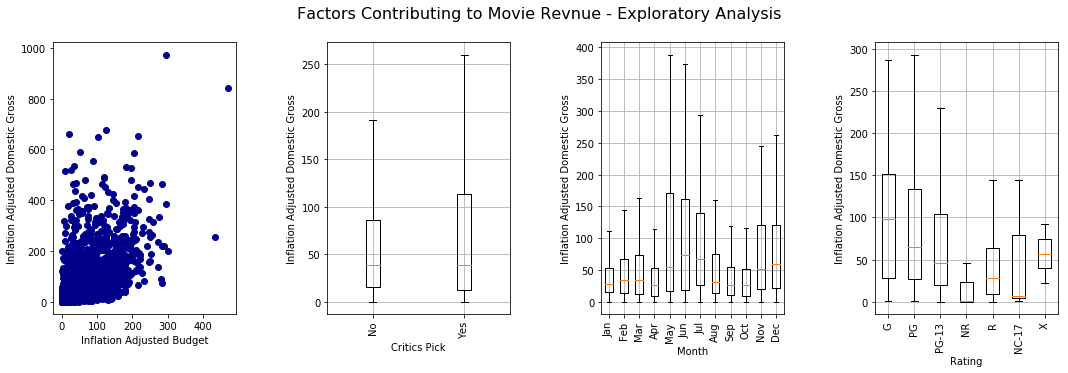

In [86]:
# Merge Budget and Revnue Data with NYT data
result = pd.merge(nyt_data, budget_revenue, on=['display_title'])
result['infl_adj_budget'] = pd.to_numeric(result['infl_adj_budget'], errors='coerce')
result = result[(result['infl_adj_budget']>0) & (result['infl_adj_DomesticGross']>0)]
result['ROI'] = result.eval('infl_adj_DomesticGross/infl_adj_budget-1')
result = result.set_index('display_title')

# Some movies have the exact same title which we are not able to differentiate which is which, we will throw these out ~200 movies
result = result[~result.index.duplicated(keep=False)]

bxplot_data = [result[result['Month']=='Jan']['infl_adj_DomesticGross'],
              result[result['Month']=='Feb']['infl_adj_DomesticGross'],
              result[result['Month']=='Mar']['infl_adj_DomesticGross'],
              result[result['Month']=='Apr']['infl_adj_DomesticGross'],
              result[result['Month']=='May']['infl_adj_DomesticGross'],
              result[result['Month']=='Jun']['infl_adj_DomesticGross'],
              result[result['Month']=='Jul']['infl_adj_DomesticGross'],
              result[result['Month']=='Aug']['infl_adj_DomesticGross'],
              result[result['Month']=='Sep']['infl_adj_DomesticGross'],
              result[result['Month']=='Oct']['infl_adj_DomesticGross'],
              result[result['Month']=='Nov']['infl_adj_DomesticGross'],
              result[result['Month']=='Dec']['infl_adj_DomesticGross']]

bxplot_data2 = [result[result['mpaa_rating']=='G']['infl_adj_DomesticGross'],
              result[result['mpaa_rating']=='PG']['infl_adj_DomesticGross'],
              result[result['mpaa_rating']=='PG-13']['infl_adj_DomesticGross'],
              result[result['mpaa_rating']=='Not Rated']['infl_adj_DomesticGross'],
              result[result['mpaa_rating']=='R']['infl_adj_DomesticGross'],
              result[result['mpaa_rating']=='NC-17']['infl_adj_DomesticGross'],
              result[result['mpaa_rating']=='X']['infl_adj_DomesticGross']]

bxplot_data3 = [result[result['critics_pick']==0]['infl_adj_DomesticGross'],
              result[result['critics_pick']==1]['infl_adj_DomesticGross']]

fig, ax1 = plt.subplots(1, 4,figsize=(18,5))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

ax1[2].boxplot(bxplot_data,showfliers=False)
ax1[2].set_xlabel('Month')
ax1[2].set_xticklabels(labels=['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],rotation = 90)
ax1[2].set_ylabel('Inflation Adjusted Domestic Gross')
ax1[2].grid(True)

ax1[0].scatter(x='infl_adj_budget',y='infl_adj_DomesticGross',c='DarkBlue',data=result)
ax1[0].set_xlabel('Inflation Adjusted Budget')
ax1[0].set_ylabel('Inflation Adjusted Domestic Gross')

ax1[3].boxplot(bxplot_data2,showfliers=False)
ax1[3].set_xlabel('Rating')
ax1[3].set_xticklabels(labels=['G','PG','PG-13','NR','R','NC-17','X'],rotation = 90)
ax1[3].set_ylabel('Inflation Adjusted Domestic Gross')
ax1[3].grid(True)

ax1[1].boxplot(bxplot_data3,showfliers=False)
ax1[1].set_xlabel('Critics Pick')
ax1[1].set_xticklabels(labels=['No','Yes'],rotation = 90)
ax1[1].set_ylabel('Inflation Adjusted Domestic Gross')
ax1[1].grid(True)

fig.suptitle('Factors Contributing to Movie Revnue - Exploratory Analysis', fontsize=16)
plt.show()

#### Method 1 - Multiple Linear Regression - All Movies

To determine if NYT critics could predict box office success a multiple linear regression model was fit to the data (the data consisting of movies the NYT reviewed, where budget and revenue data also existed).

For any given movie the model is able to predict inflation adjusted domestic gross (adjusted to 2015 dollars) using the explanatory variables: inflation adjusted budget, whether the movie was rated as a NYT critics' pick, the month the movie was released in, and the MPAA rating assigned to the movie.

Movies in May/June/July/November/December tend to exhibit higher revenue numbers than other months; this is supported by the tendency for movie studios to release 'summer blockbusters' or 'Christmas blockbusters'. For this reason the model adjusts projected revenues based on if a movie is released in these months.

Movies with different ratings also tend to have different revenue characteristics. This is supported by the intuition that if a movie is rated higher (i.e. rated R instead of G) the potential audience for a movie shrinks. For this reason the model adjusts projected revenues based on if a movie is G rated, PG or PG-13 rated, or falls into another rating category (Not Rated/R/NC17/X).

In [87]:
X_cols = ['infl_adj_budget','critics_pick']
X = result[X_cols]

# add rating dummy variables
rating_dummies = pd.get_dummies(result['mpaa_rating'])
X = pd.merge(X, rating_dummies, on='display_title',how='inner')

# add month dummy variables
month_dummies = pd.get_dummies(result['Month'])
X = pd.merge(X, month_dummies, on='display_title',how='inner')
y = result['infl_adj_DomesticGross']

# Combine some rating & dummy variable columns
X['MayJunJulNovDec'] = X['May'] + X['Jun'] + X['Jul'] + X['Nov'] + X['Dec']
X = X.drop(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'],axis=1)

# all profitable months as one indicator
X['NotRated/R/NC17/X'] = X['Not Rated'] + X['R'] + X['X'] + X['NC-17']
X['PG/PG13'] = X['PG'] + X['PG-13']

# Drop dummy variables
X = X.drop(['Not Rated','R','X','NC-17','PG','PG-13'],axis=1)

# Reorder Columns
X = X[['infl_adj_budget','critics_pick','MayJunJulNovDec','G','PG/PG13','NotRated/R/NC17/X']]
X = sm.add_constant(X)

# Drop large residuals associated with these three movies
X = X.drop(['Titanic','Avatar','Pirates of the Caribbean: On Stranger Tides'])
y = y.drop(['Titanic','Avatar','Pirates of the Caribbean: On Stranger Tides'])

least_squares = sm.OLS(y, X)

#fit the model
model1 = least_squares.fit()
print(model1.summary())

                              OLS Regression Results                              
Dep. Variable:     infl_adj_DomesticGross   R-squared:                       0.365
Model:                                OLS   Adj. R-squared:                  0.363
Method:                     Least Squares   F-statistic:                     269.3
Date:                    Mon, 12 Nov 2018   Prob (F-statistic):          7.65e-273
Time:                            23:57:55   Log-Likelihood:                -15955.
No. Observations:                    2821   AIC:                         3.192e+04
Df Residuals:                        2814   BIC:                         3.196e+04
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

<div class="alert alert-block alert-success">
<b>Conclusion 1 - Multiple Linear Regression:</b> Observing the critics_pick variable in the regression output we notice it is statistically significant and is positively associated with movies' inflation adjusted domestic gross. Based on this test it appears NYT critics are successful at choosing box office hits, and that being rated as a critics' pick is associated with a movie earning roughly \$18mm more (in 2015 dollars) at the box office than a movie that was not a critics' pick.
</div>

<div class="alert alert-warning" role="alert">
  <h4 class="alert-heading">Conclusion 1 - Limitations</h4>
  <p>It is worth noting that this simple model was only able to achieve a R-squared (the percent of variation in the data explained by the model) of 36.5%. This speaks to the fact that there are many other factors which affect movies' box office success, and the model is only able to capture a portion of this.</p>
</div>

#### Method 2 - Logistic Regression  - Big Budget Movies

This analysis asks a slightly different question. Specifically, are NYT critics able to discern what films will be financially successful. Here we define financially successful as ROI, the percentage return a film makes based on its budget. Given ROIs for small movies can be very erratic we restrict our analysis to movies with a budget of at least \$50mm, and define successful as being in the top 25% of films in this category by ROI.

In [88]:
big_films = result[result['infl_adj_budget']>50]
big_films['Success']=pd.get_dummies(big_films['ROI']>big_films['ROI'].quantile(.75))[True]

X2 = big_films[['critics_pick']]
X2 = sm.add_constant(X2)
y2 = big_films['Success'].values

model2 = sm.Logit(y2,X2)
logit_res = model2.fit()
print(logit_res.summary2())

Optimization terminated successfully.
         Current function value: 221.422039
         Iterations 5
                          Results: Logit
Model:              Logit            No. Iterations:   5.0000     
Dependent Variable: y                Pseudo R-squared: -0.054     
Date:               2018-11-12 23:57 AIC:              410520.4601
No. Observations:   927              BIC:              410530.1240
Df Model:           1                Log-Likelihood:   -2.0526e+05
Df Residuals:       925              LL-Null:          -1.9477e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
const         -1.2692    0.0863  -14.7070  0.0000  -1.4384  -1.1001
critics_pick   0.9447    0.1902    4.9680  0.0000   0.5720   1.3175



<div class="alert alert-block alert-success">
<b>Conclusion 2 - Logistic Regression - Big Budget Movies:</b> Logistic regression shows a fairly significant positive relationship between a movie being a critics' pick and it acheiving financial success. According to the model, 42% of movies that are critics' picks are financially successful, versus only 22% of movies that are not critics' picks are financially successful. Therefore it does appear that NYT critics are able to predict which movies will be financially succesful.
</div>

<a id='plotclass'></a>

<a id='question2'></a>
# 2. What kind of storylines do NYT critics favour?

#### Method 3 - Classification Trees - Bigrams

In order to determine what type of storylines NYT critics favour we utilize classification trees. First we vectorize each movie's plot description based on the bigrams (pairs of consecutive words) contained in it. For example if MovieA's plot is 'Dog runs away fast' and MovieB's plot is 'Crew sails away fast' the vectorized representation of these would be.

<br>

<center>
$
\begin{bmatrix}
     & dog \: runs & runs \: away & away \: fast  & crew \: sails & sails \: away \\
    MovieA & 1 & 1 & 1  & 0 & 0 \\
    MovieB & 0 & 0 & 1  & 1 & 1
\end{bmatrix}
$
</center>

Using entropy (a measure of how equally distributed a set of movies are between critics' picks and not critics' picks) the classification tree will at each step select a bigram that appears to do a good job of explaining if a given movie is a critics' pick or not, and splits the data based on movies that contain this bigram in their plot and those that do not. By observing the top levels of the classification tree the analysis shows which bigrams are most informative as to whether a movie will be a critics' pick.

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import string
import pydotplus
import graphviz
from IPython.display import Image  

In [90]:
movie_plot_df3 = movielens_database
movie_plot_df3 = movie_plot_df3[['title','overview']]
movie_plot_df3 = movie_plot_df3.rename(columns={'title': 'display_title'})
nyt_bare_bones = nyt_data[['display_title','critics_pick','opening_date']]

nyt_plot_picks2 = pd.merge(nyt_bare_bones,movie_plot_df3,on=['display_title'])
nyt_plot_picks2 = nyt_plot_picks2.set_index('display_title')
nyt_plot_picks2 = nyt_plot_picks2[~nyt_plot_picks2.index.duplicated(keep=False)]
nyt_plot_picks2['overview'] = nyt_plot_picks2['overview'].str.lower()

In [91]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(['come','san','film','oscar','nominated'])
vectorizer = CountVectorizer(stop_words=my_stop_words,analyzer='word',ngram_range=(2, 2))

corpus = vectorizer.fit_transform(nyt_plot_picks2['overview'].values.astype('U'))

model_feature_names = vectorizer.get_feature_names()

X_tree = corpus
y_tree = nyt_plot_picks2['critics_pick'].values

clf1 = DecisionTreeClassifier(random_state=1,criterion='entropy',max_depth=4)
clf2 = DecisionTreeClassifier(random_state=1,criterion='entropy',max_depth=30)
model_small = clf1.fit(X_tree,y_tree)
model_large = clf2.fit(X_tree,y_tree)

Below is the top four layers of the thirty layer classification tree that was used. As one can see, movie plots that contain the words 'upper middle', 'andy toys', 'trade center', and 'day year' were all rated as critics' picks. 

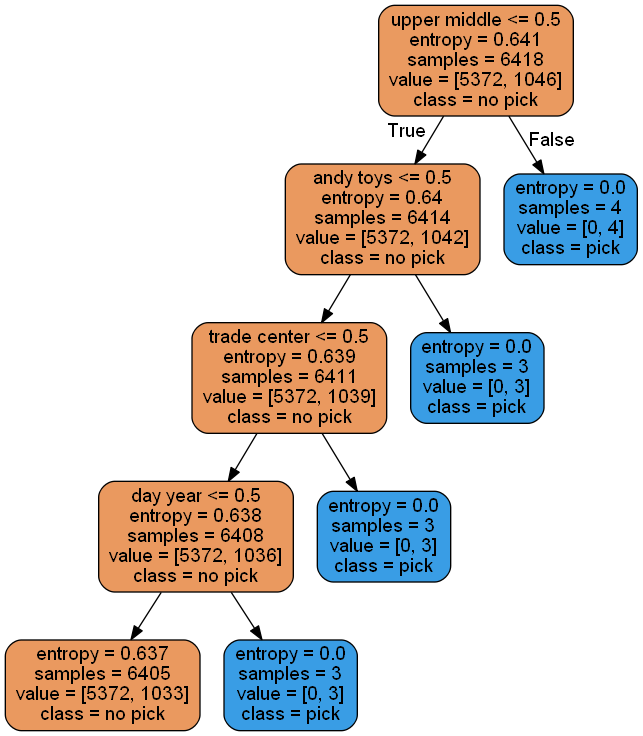

In [92]:
# Print the classification tree
dot_data = tree.export_graphviz(clf1, filled=True,rounded=True,out_file=None,
                                feature_names=model_feature_names,class_names=['no pick','pick'])
    
graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

Looking at the full thirty layer classification tree we see the following bigrams frequently present in the plots of movies that were chosen as critics' picks.

In [93]:
ftr_importances = model_large.feature_importances_
important_feature_idx = np.where(ftr_importances >0.01)
important_feature_idx = important_feature_idx[0].tolist()

important_features=[]

for ftr_idx in important_feature_idx:
    important_features.append(model_feature_names[ftr_idx])

print(important_features)

['20th century', 'al gore', 'andy toys', 'anti semitism', 'austin texas', 'begin boss', 'big sur', 'boy living', 'century seen', 'chaotic world', 'day year', 'documentary girls', 'drug fueled', 'eighty year', 'events involving', 'journey ancient', 'khmer rouge', 'kyuta boy', 'loss mother', 'lover leaves', 'man dies', 'martial arts', 'north london', 'offers glimpse', 'prepares legendary', 'rock roll', 'series events', 'series flashbacks', 'smooth talking', 'status quo', 'story world', 'ticking time', 'trade center', 'upper middle', 'violent outbursts', 'wedding anniversary', 'wishes mother']


<div class="alert alert-success" role="alert">
  <h4 class="alert-heading">Conclusion 3 - Classification Trees - Bigrams</h4>
  <p>A few interesting themes emerge which point to the type of movies critics like. 

Notably, plots which contain the words 'al gore', 'trade center', and 'upper middle' are favoured by the NYT reviewers. This somewhat fits the stereotype of what many would see as the average NYT subscriber; New Yorkers who are well-to-do and  politically left-leaning. Since the writers of the NYT are likely to be similar to the NYT readership, it is unsurprising that the NYT critics selected movies with these plot characteristics. There also appears to be a preference for tragic stories as evidenced by the following bigrams: 'loss mother', 'lover leaves', and 'man dies'. As well there is a preference for 'edgy' movies through the bigrams: 'drug fueled', 'chaotic world', and 'rock roll' (which is equivalent to 'rock and roll' given the classifier removes stop words such as 'and', 'or', 'the').</p>
</div>

<div class="alert alert-warning" role="alert">
  <h4 class="alert-heading">Conclusion 3 - Limitations</h4>
  <p>It must be noted that there are significant limitations of using classification trees in this manner.</p>
  <p class="mb-0">The number of bigrams in movie plots is quite large, and many bigrams will only appear once across all movie titles. In the above analysis, a 30 layer classification tree (which is a fairly deep tree) is only able to correctly identify ~9% of movies that were critics' picks. Part of the reason for this is the algorithm is fairly 'simple' in the sense it is unable to identify similar bigrams and treat them as if they were the same. For example 'man runs', 'man sprints', 'men run', and 'men sprint', would be treated as separate bigrams when in reality they are expressing the same idea. Further analysis on this question could include looking at more advanced natural language processing techniques such as document classification.</p>
</div>

<a id='question3'></a>
# 3. What best picture nominees tend to win the Oscar?

To answer the above question we analyze the data in the following ways:

1. A two sample t-test to see if movies that win the best picture Oscar have higher IMDB user ratings than those that do not win.
1. A two sample t-test to see if movies that win the best picture Oscar have longer runtimes than those that do not win.
2. A look at the distribution of genres for films that win the best picture Oscar versus those that do not win.

#### Method 4 - Two Sample T-Test - IMDB User Ratings

A Two Sample T-Test is conducted to determine if the preferences of American Academy of Arts and Sciences with respect to Oscar best picture tends to match that of the general public.

In [94]:
oscar_data = oscar_data[oscar_data['category']=='BEST PICTURE']

# Remove movies that OMDB does not have
oscar_data = oscar_data[oscar_data['entity'] != 'Meredith Willson\'s The Music Man']
oscar_data = oscar_data[oscar_data['entity'] != 'Cries and Whispers']
oscar_data = oscar_data[oscar_data['entity'] != 'Good Fellas']
oscar_data = oscar_data[oscar_data['entity'] != 'The Postman (Il Postino)']
oscar_data = oscar_data[oscar_data['entity'] != 'Les Misérables']
oscar_data = oscar_data.set_index('entity')
oscar_data = oscar_data.rename(columns={'year': 'oscar_year'})

movie_metadata = movielens_database
movie_metadata = movie_metadata.rename(columns={'original_title': 'entity'})
oscar_merged = pd.merge(oscar_data, movie_metadata, how='left', on=['entity'])
oscar_merged['release_year'] = pd.DatetimeIndex(oscar_merged['release_date']).year
oscar_merged['year_diff'] = oscar_merged['release_year'] - oscar_merged['oscar_year']
oscar_merged = oscar_merged[(np.absolute(oscar_merged['year_diff'])<2) | (oscar_merged['year_diff'].isnull())]
oscar_merged['release_year'] = oscar_merged['release_year'].fillna(0)
oscar_merged['release_year'] = oscar_merged['release_year'].astype(int)

# drop movies that got duplicated
oscar_merged = oscar_merged.drop([205,325])

oscar_loop = oscar_merged[['entity','oscar_year','release_year','winner']].values

# Loop to Get Oscar Movie info from OMDB, run once, wrote to CSV file

# omdb_df = pd.DataFrame()
# apikey_omdb = "ab8ac07e"

# for movie_title, oscar_year,release_year,winner in oscar_loop: 
#     movie = movie_title
#     title = 't=' + movie_title.replace(' ', '+')
    
#     if release_year == 0:
#         req = ('http://www.omdbapi.com/?apikey='+ apikey_omdb + '&'+ title + '&plot=full')
#         response = pd.read_json(req)
#         omdb_df = omdb_df.append(response.iloc[0])
#     else:
#         req = ('http://www.omdbapi.com/?apikey='+ apikey_omdb + '&'+ title + '&plot=full' + 'y='+ str(release_year))
#         response = pd.read_json(req)
#         omdb_df = omdb_df.append(response.iloc[0])
        
# omdb_df.to_csv('OscarNomineeOMBD.csv', encoding='utf-8', index=False)

omdb_df['winner'] = oscar_merged['winner'].values
omdb_df['release_year'] = oscar_merged['release_year'].values
omdb_df['oscar_year'] = oscar_merged['oscar_year'].values
omdb_df['Year']= pd.to_numeric(omdb_df['Year'], errors='coerce')
omdb_df['imdbVotes'] = omdb_df['imdbVotes'].str.replace(',','')
omdb_df['imdbVotes']= pd.to_numeric(omdb_df['imdbVotes'], errors='coerce')
omdb_df['Runtime'] = omdb_df['Runtime'].str.replace(' min','')
omdb_df['Runtime'] = pd.to_numeric(omdb_df['Runtime'],errors='coerce')

# remove movies that year is not right 
# this sometimes happens if OMDB not able to pull correct movie despite being given year and title
omdb_df = omdb_df[(omdb_df['release_year']==0) |(omdb_df['release_year']==omdb_df['Year'])]
omdb_df['release_year'] = omdb_df['Year']

# drop a random movie that comes out incorrectly
omdb_df = omdb_df.drop(21)

Two Sample T-Test Results - IMDB User Ratings

Best Picture Losers  - Average IMDB User Rating - 7.68
Best Picture Winners - Average IMDB User Rating - 7.99

P Value Associated With Two Sample T-Test 0.00000932



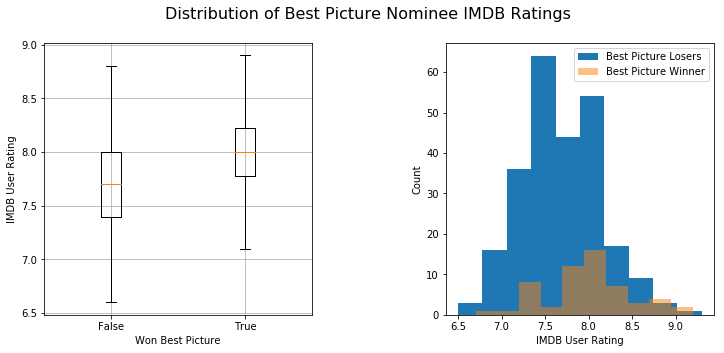

In [95]:
from decimal import *

bxplot_data4 = [omdb_df[omdb_df['winner']==False]['imdbRating'],
              omdb_df[omdb_df['winner']==True]['imdbRating']]

fig, ax = plt.subplots(1, 2,figsize=(12,5))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

ax[0].boxplot(bxplot_data4,showfliers=False)
ax[0].set_xlabel('Won Best Picture')
ax[0].set_xticklabels(labels=['False','True'])
ax[0].set_ylabel('IMDB User Rating')
ax[0].grid(True)

ax[1].hist(omdb_df[omdb_df['winner']==False]['imdbRating'],label='Winner')
ax[1].hist(omdb_df[omdb_df['winner']==True]['imdbRating'],alpha=0.5,label='Loser')
ax[1].set_xlabel('IMDB User Rating')
ax[1].set_ylabel('Count')
ax[1].legend(['Best Picture Losers','Best Picture Winner'])

fig.suptitle('Distribution of Best Picture Nominee IMDB Ratings', fontsize=16)

from scipy import stats
print('Two Sample T-Test Results - IMDB User Ratings')
print('')
print('Best Picture Losers  - Average IMDB User Rating -',round(omdb_df[omdb_df['winner']==False]['imdbRating'].mean(),2))
print('Best Picture Winners - Average IMDB User Rating -',round(omdb_df[omdb_df['winner']==True]['imdbRating'].mean(),2))
print('')
print('P Value Associated With Two Sample T-Test',round(Decimal(stats.ttest_ind(omdb_df[omdb_df['winner']==False]['imdbRating'],omdb_df[omdb_df['winner']==True]['imdbRating'])[1]),8))
print('')

In [96]:
import plotly.plotly as py
import plotly.graph_objs as go

trace0 = go.Scatter(
    x = omdb_df[omdb_df['winner']==False]['oscar_year'].values,
    y = omdb_df[omdb_df['winner']==False]['imdbRating'].values,
    name = 'Best Picture Losers',
    mode = 'markers',
    text = omdb_df[omdb_df['winner']==False]['Title'].values,
    marker = dict(
        size = 10,
        color = 'blue',
        line = dict(
            width = 2,
            color = 'blue'
        )
    )
)

trace1 = go.Scatter(
    x = omdb_df[omdb_df['winner']==True]['oscar_year'].values,
    y = omdb_df[omdb_df['winner']==True]['imdbRating'].values,
    name = 'Best Picture Winners',
    mode = 'markers',
    text = omdb_df[omdb_df['winner']==True]['Title'].values,
    marker = dict(
        size = 10,
        color = 'orange',
        line = dict(
            width = 2,
            color = 'orange'
        )
    )
)

layout=go.Layout(title="Oscar Best Picture Nominee IMDB User Ratings", hovermode='closest',
                 xaxis={'title':'Oscar Year'}, yaxis={'title':'IMDB User Rating'})

data = [trace0,trace1]

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='styled-scatter')

<div class="alert alert-success" role="alert">
  <h4 class="alert-heading">Conclusion 4 - Two Sample T-Test - IMDB User Ratings</h4>
  <p>We conclude that yes, the movies that the American Academy of Arts and Sciences choose to win best picture tend to have higher IMDB user ratings relative to the best picture losers. This would suggest the Academy has broadly similar preferences to the general public.</p>
</div>

<div class="alert alert-warning" role="alert">
  <h4 class="alert-heading">Conclusion 4 - Limitations</h4>
  <p>One limitation that should be noted is that IMDB ratings are a relatively recent feature of the site, and many of the movies would have been rated by users who watched the movie knowing if it won the best picture Oscar or not. This could potentially bias IMDB user ratings for best picture winners upwards. That being said, the low ratings for best picture winners such as Tom Jones (1963), Oliver! (1968), and Chariots of Fire (1981) would suggest the bias is unlikely to be too great.</p>
</div>

#### Method 5 - Two Sample T-Test - Movie Runtimes

A Two Sample T-Test is conducted to determine if the best picture winners have statistically significantly longer runtimes than the best picture losers.

In [97]:
print('Two Sample T-Test Results - Movie Runtimes')
print('')
print('Best Picture Losers  - Average Runtime -',round(omdb_df[omdb_df['winner']==False]['Runtime'].mean(),2))
print('Best Picture Winners - Average Runtime -',round(omdb_df[omdb_df['winner']==True]['Runtime'].mean(),2))
print('')
print('P Value Associated With Two Sample T-Test',round(Decimal(stats.ttest_ind(omdb_df[omdb_df['winner']==False]['Runtime'],omdb_df[omdb_df['winner']==True]['Runtime'])[1]),8))
print('')

trace1 = go.Histogram(
    x=omdb_df[omdb_df['winner']==False]['Runtime'],
    name='Best Picture Losers',
    opacity=1,
    nbinsx=15
)
trace2 = go.Histogram(
    x=omdb_df[omdb_df['winner']==True]['Runtime'],
    name='Best Picture Winners',
    opacity=0.5,
    nbinsx=15
)

data = [trace1, trace2]
layout = go.Layout(barmode='overlay', title="Oscar Best Picture Nominee Runtimes", xaxis={'title':'Runtime (minutes)'}, yaxis={'title':'Count'})
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

Two Sample T-Test Results - Movie Runtimes

Best Picture Losers  - Average Runtime - 128.7
Best Picture Winners - Average Runtime - 140.64

P Value Associated With Two Sample T-Test 0.00139600



<div class="alert alert-success" role="alert">
  <h4 class="alert-heading">Conclusion 5 - Two Sample T-Test Results - Movie Runtimes</h4>
  <p>Using a two sample t-test we see that the runtime of Oscar best picture winning movies are statistically significantly higher than those that do not win.</p>
</div>

#### Method 6 - Distribution of Movie Genres

Below we plot the genres of the movies that win or lose the Oscar best picture (note each movie can have more than one genre associated with it).

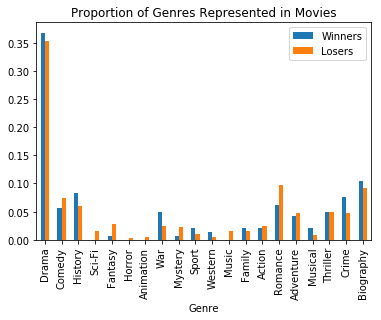

In [98]:
# Differences in Genres
genre_list = omdb_df['Genre'].tolist()
genre_list = ', '.join(genre_list)
genre_list = genre_list.replace(" ", "")
genre_list = genre_list.split(',')
unique_genres = set(genre_list)
unique_genres

genre_df = pd.DataFrame()
winner_genres = omdb_df[omdb_df['winner']==True]['Genre'].tolist()
winner_genres = ', '.join(winner_genres)
winner_genres = winner_genres.replace(" ", "")
winner_genres = winner_genres.split(',')
total_winner_genres = len(winner_genres)

loser_genres = omdb_df[omdb_df['winner']==False]['Genre'].tolist()
loser_genres = ', '.join(loser_genres)
loser_genres = loser_genres.replace(" ", "")
loser_genres = loser_genres.split(',')
total_loser_genres = len(loser_genres)

for genre in unique_genres:
    genre_df = genre_df.append([[genre,
                                 winner_genres.count(genre)/total_winner_genres,
                                 loser_genres.count(genre)/total_loser_genres]])

genre_df = genre_df.set_index(0)
genre_df = genre_df.rename(columns={1: 'Winners',2:'Losers'})
genre_df.plot(kind='bar',title='Proportion of Genres Represented in Movies')
plt.xlabel('Genre')
plt.show()

<div class="alert alert-success" role="alert">
  <h4 class="alert-heading">Conclusion 5 - Distribution of Movie Genres - Movie Runtimes</h4>
  <p>Given the small sample size for each genre it is challenging to make definitive statistical conclusions. That being said, we can likely conclude two things from the above chart. First, it appears that dramas appear to be well-represented among best picture nominees and winners. Second, romance and comedy movies tend to be nominated and not win best picture. And lastly, when crime, history, and war movies are nominated, they more frequently win than lose.</p>
</div>

<a id='conclusion'></a>
# CONCLUSION

In summary, the data was able to offer great insight into how critics at both the NYT and the Academy choose their favourite movies. Particularly we found that:

* NYT's critics do have a meaningful ability to predict what films will be box office hits.
* NYT critics are biased towards liking movies with certain plot themes. In particular they enjoy movies with plot summaries that contain the New York centric bigrams: 'al gore', 'trade center', 'upper middle'; tragic story bigrams: 'loss mother', 'lover leaves', 'man dies'; and 'edgy' bigrams such as: 'drug fueled', 'chaotic world', and 'rock roll'.
* The movies the Academy chooses for the best picture Oscar tend to be rated higher on IMDB relative to best picture losers. Also, movies that win best picture tend to have longer runtimes. And finally, best picture nominees that are from the crime, history, or war genre tend to win the Oscar more often than not.